In [7]:
import torch
import RVIB
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

Time series simulation

In [8]:
def get_trend(T = 100, time_slope = 25):
    
    t = int((T-2*time_slope)/4)
    
    x1 = np.zeros(t)
    x_pente = np.linspace(0,1,num=time_slope)

    x2 =  np.zeros(( 2*t))
    x2 += 1

    x = np.concatenate([x1,x_pente, x2, (-x_pente+1), x1])
    drift = T - len(x)
    if drift>0:
        x = np.concatenate([np.zeros(drift),x])
    return x

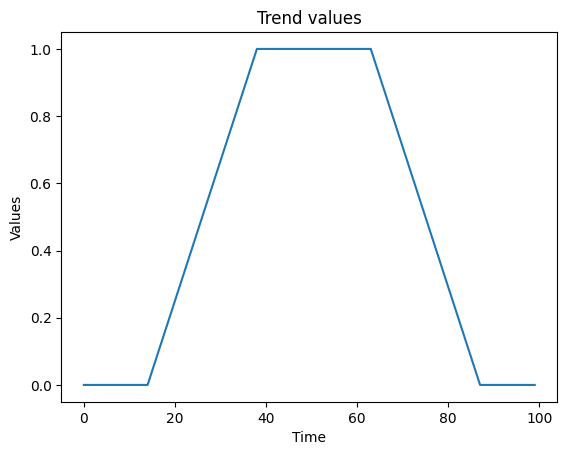

In [50]:
trend = get_trend()
plt.title("Trend values")
plt.plot(trend)
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [17]:
# 1. Characterize the gaussian noise in the whole time series (N1)
def bell_shape_f(x,a,m,s):
    return a*np.exp(-(x-m)**2/(2*(s**2)))

def get_dynamic_noise(l=100,n_period=4,t_param=0.2,max_noise=0.5):
    x = np.linspace(0,1,int(l/n_period))
    # Add 0 in the begining if the leng/n_period has euclidian residual
    noise_dynamics = np.concatenate([bell_shape_f(x,max_noise,0.5,t_param)]*n_period)
    drift = l - len(noise_dynamics)
    if drift>=0:
        n_start = np.zeros(drift)
        noise_dynamics = np.concatenate([n_start,noise_dynamics]) 
    return noise_dynamics

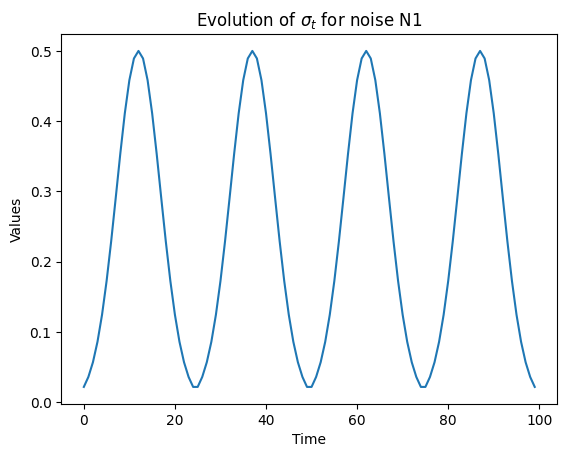

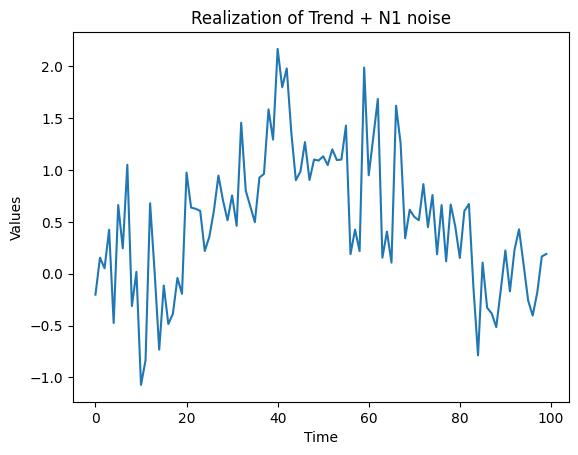

In [49]:
n1_std = get_dynamic_noise(100)
plt.title("Evolution of $\sigma_t$ for noise N1")
plt.plot(n1_std)
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()
plt.title("Realization of Trend + N1 noise")
plt.plot(trend + np.random.normal(loc = np.zeros(len(n1_std)),scale=np.sqrt(n1_std)))
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [28]:
# 2. Charactereize the skew noise (N2) and return a realization series
def get_noisy_ts(trend,n1_std,pois_lam=3,noise_scale=0.5):
    """
    Adding noise to the trend timeseries
    """
    
    # Identify when trend-change is occuring
    trend_p1 = np.argmax(trend>0)
    trend_p2 = np.argmax(trend==1)
    trend_l = trend_p2 - trend_p1
        
    trend_inv = trend[::-1]
    leng = len(trend_inv)
    trend_p3 = leng - np.argmax(trend_inv==1) - 1
    trend_p4 = leng - np.argmax(trend_inv>0) - 1
    
    #1. Add gaussian noise in the series
    trend_n1 = np.random.normal(loc=trend,scale=n1_std)
    
    # 2. Add unexpected noise in the change of the trend according a poissin distrubtion and a skew normal noise
    ## 2.1 when it goes up
    pois = np.random.poisson(lam=pois_lam,size=trend_l)
    npois = [skewnorm.rvs(.5,loc=0,scale=noise_scale,size = s).sum() for s in pois]
    
    trend_n12 = trend_n1.copy()
    trend_n12[trend_p1:trend_p2] += npois
    
    ## 2.2 when it goes down
    pois = np.random.poisson(lam=pois_lam,size=trend_l)
    npois = [skewnorm.rvs(-.5,loc=0,scale=noise_scale,size = s).sum() for s in pois]
    trend_n12[trend_p3:trend_p4] += npois
    
    return trend_n1,trend_n12

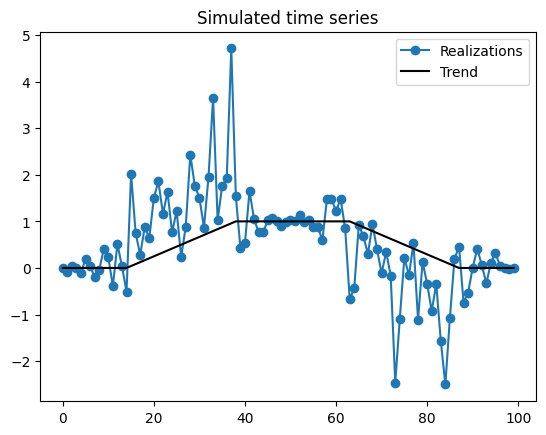

In [45]:
trend_n1,trend_n12 = get_noisy_ts(trend,n1_std)
plt.title("Simulation of 1 sequence")
plt.plot(trend_n12,'-o',c='C0',label='Realizations')
plt.plot(trend,c='black',label='Trend')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [35]:
# 3. Repeat 10 times and make a dataset for training a supervised algorithm
def get_xy_from_simul(trend,n1_std,noise_scale=.5,pois_lam=3,n_concat=10):
    x = []
    x_noise = []
    for i in range(n_concat):
        samp,samp_noise = get_noisy_ts(trend,n1_std,noise_scale=noise_scale,pois_lam=pois_lam)
        x.append(samp)
        x_noise.append(samp_noise)
    x = np.concatenate(x)
    x_noise = np.concatenate(x_noise)
    y = np.concatenate([trend]*10)
    
    return x,x_noise,y

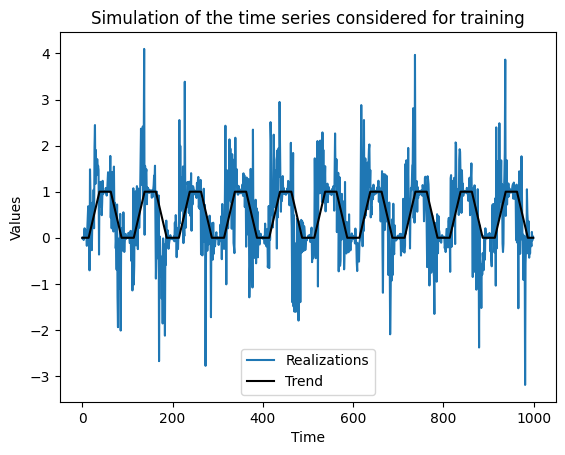

In [48]:
x,x_noise,y = get_xy_from_simul(trend,n1_std)
plt.title("Simulation of the time series considered for training")
plt.plot(x_noise,c='C0',label='Realizations')
plt.plot(y,label='Trend',c='black')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

# Preprocess the simulated time series for training RVIB model

The trend is suppose to be unknwon. The learning algorithm is fed with a sequence of time series with size *window* and the target is the next value of the sequence.

In [98]:
def window_sample(x,y,window):
    """
    From X (TS values) and Y(the trend), make a table with each row corresponding to a sequence of size *window*.
    """
    n_sample_new = len(x) - window + 1
    x_new = np.zeros((n_sample_new,window))
    y_new_class = np.zeros(n_sample_new)
    for i in range(n_sample_new):
        x_new[i,:] = x[i:i+window]
        y_new_class[i] = y[i+window - 1]
    return x_new,y_new_class

def regression_sample(x_window,return_torch = False):
    """
    From the table of sequences (below), return the sequence and the next value of the sequence.
    """
    
    if return_torch:
        x_window = torch.tensor(x_window,dtype=torch.float)
    
    x_new_reg = x_window[:-1]
    y_new_reg = x_window[1:,-1]
    
    return x_new_reg,y_new_reg

def process_data(x,y,window,batch_size = 8, shuffle = True):
    """
    Return trainable dataset with PyTorch DataLoader.
    The dataloader containes the input dataset and the next values.
    y_train_trend is the corresponding trend values.
    """

    x_train,y_train_trend = window_sample(x,y,window)
    x_train,y_train = regression_sample(x_train,return_torch=True)
    y_train_trend = torch.tensor(y_train_trend[1:],dtype=torch.float)
    train_loader_reg = RVIB.get_dataloader(x_train[...,np.newaxis],y_train,batch_size=batch_size,shuffle=shuffle) # shuffle is set to False to be able to keep the time logic. results with shuffle is the same

    return train_loader_reg,y_train_trend

In [66]:
train_loader,y_train_trend = process_data(x_noise,y,window=10)
# The input data has the shape of (n_smaple, time_dim, n_feature)
print(train_loader.dataset.X.shape)

torch.Size([990, 10, 1])


In [79]:
from importlib import reload
reload(RVIB)

Initialize RVIB model in a single dimension

In [85]:
# One dimensional RVIB
# Initialization
rvib = RVIB.RVIB_GRU(input_dim=1,time_dim=10,beta=1e-1,z_dim=1)
# Training the algorith, with warm start which allows to reduce the KL values 
rvib.fit(train_loader,epoch=300,lr=1e-3,warm_start=True)

KL divergence warm_start ended with KL loss= 2.678711414337158


100%|██████████| 300/300 [01:37<00:00,  3.08it/s, Loss=0.557, kl loss=0.318, MSE=0.506, beta=0.1]


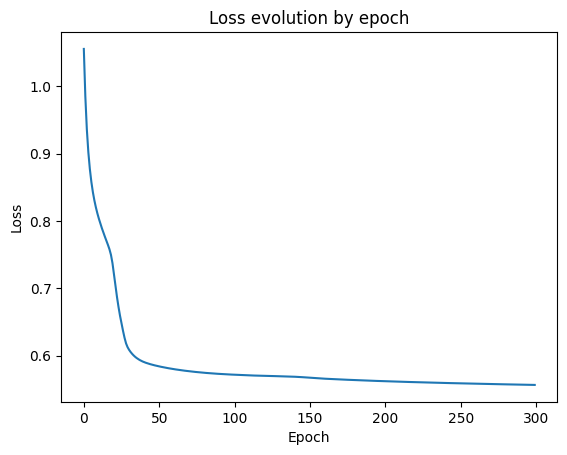

In [89]:
plt.title("Loss evolution by epoch")
plt.plot(rvib.lh)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [95]:
# Retrieve the infroFrom PyTorch DL model
x_train = train_loader.dataset.X
y_train = train_loader.dataset.y
with torch.no_grad():
    y_hat_train,Mu,Std = rvib(x_train)
    mse_train = ((y_train - y_hat_train)**2).mean()
    mse_trend = ((y_train_trend - y_hat_train)**2).mean()

In [96]:
print("MSE vs samples",mse_train)
print("MSE vs trend",mse_trend)

MSE vs samples tensor(0.5055)
MSE vs trend tensor(0.0169)


In [99]:
# Test dataset with new simulation
x_test,x_test_noise,y_test_trend = get_xy_from_simul(trend,n1_std)
test_loader,y_test_trend = process_data(x_test_noise,y_test_trend,window=10,shuffle=False) # Do not shuffle to keep time consistent data

In [103]:
# EValuate on test dataset
x_test = test_loader.dataset.X
y_test = test_loader.dataset.y
with torch.no_grad():
    y_hat_test,Mu,Std = rvib(x_test)
    mse_test = ((y_test - y_hat_test)**2).mean()
    mse_trend_test = ((y_test_trend - y_hat_test)**2).mean()

In [104]:
print("MSE vs samples",mse_test)
print("MSE vs trend",mse_trend_test)

MSE vs samples tensor(0.5594)
MSE vs trend tensor(0.0197)
